# Advanced DataFrames Exercises Part 1

1. Run `python -m pip install pymysql` from your terminal to install the mysql client (any folder is fine)

2. cd into your exercises folder for this module and run `echo env.py >> .gitignore`
3. Create a function named `get_db_url`. It should accept a username, hostname, password, and database name and return a url connection string formatted like in the example at the start of this lesson.

3. Use your function to obtain a connection to the employees database. Once you have successfully run a query:
- Intentionally make a typo in the database url. What kind of error message do you see?
- Intentionally make an error in your SQL query. What does the error message look like?

- Read the employees and titles tables into two separate DataFrames.
- How many rows and columns do you have in each DataFrame? Is that what you expected?
- Display the summary statistics for each DataFrame.
- How many unique titles are in the titles DataFrame?
- What is the oldest date in the to_date column?
- What is the most recent date in the to_date column?

In [27]:
from env import get_db_url
import pandas as pd
import numpy as np

from pydataset import data

In [3]:
url = get_db_url("employees")
sql = """
SELECT * FROM employees
"""

employees = pd.read_sql(sql, url)
employees.shape

(300024, 6)

In [4]:
sql = """
SELECT * FROM titles
"""

titles = pd.read_sql(sql, url)
titles.head()

,emp_no,title,from_date,to_date
0,10001,Senior Engineer,1986-06-26,9999-01-01
1,10002,Staff,1996-08-03,9999-01-01
2,10003,Senior Engineer,1995-12-03,9999-01-01
3,10004,Engineer,1986-12-01,1995-12-01
4,10004,Senior Engineer,1995-12-01,9999-01-01


In [5]:
titles.shape

(443308, 4)

In [6]:
employees.describe()

,emp_no
count,300024.000000
mean,253321.763392
std,161828.235540
min,10001.000000
25%,85006.750000
50%,249987.500000
75%,424993.250000
max,499999.000000


In [7]:
titles.describe(include="all")

,emp_no,title,from_date,to_date
count,443308.000000,443308,443308,443308
unique,NaN,7,6393,5888
top,NaN,Engineer,1998-10-25,9999-01-01
freq,NaN,115003,132,240124
mean,253075.034430,NaN,NaN,NaN
std,161853.292613,NaN,NaN,NaN
min,10001.000000,NaN,NaN,NaN
25%,84855.750000,NaN,NaN,NaN
50%,249847.500000,NaN,NaN,NaN
75%,424891.250000,NaN,NaN,NaN


In [8]:
# How many unique titles are in the titles DataFrame?
# Example of solving the problem only with SQL
pd.read_sql("SELECT COUNT(DISTINCT title) AS unique_title_count from titles", url)

,unique_title_count
0,7


In [9]:
# How many unique titles are in the titles DataFrame?
# pandas approach
len(titles.title.unique())

7

In [10]:
# What is the oldest date in the to_date column?
pd.read_sql("SELECT MIN(to_date) FROM titles", url)

,MIN(to_date)
0,1985-03-01


In [11]:
titles.to_date.min()

datetime.date(1985, 3, 1)

In [12]:
# What is the most recent date in the to_date column?
pd.read_sql("SELECT MAX(to_date) FROM titles", url)

,MAX(to_date)
0,9999-01-01


In [13]:
# pandas approach
titles.dtypes

emp_no        int64
title        object
from_date    object
to_date      object
dtype: object

In [14]:
# pd.to_datetime(titles.to_date) this would work except for the 9999 year.

In [15]:
titles.to_date.max()

datetime.date(9999, 1, 1)

## Part 2 Exercises

Copy the users and roles DataFrames from the examples above.

What is the result of using a right join on the DataFrames?

What is the result of using an outer join on the DataFrames?

What happens if you drop the foreign keys from the DataFrames and try to merge them?

In [19]:
users = pd.DataFrame({
    'id': [1, 2, 3, 4, 5, 6],
    'name': ['bob', 'joe', 'sally', 'adam', 'jane', 'mike'],
    'role_id': [1, 2, 3, 3, np.nan, np.nan]
})
users

,id,name,role_id
0,1,bob,1.0
1,2,joe,2.0
2,3,sally,3.0
3,4,adam,3.0
4,5,jane,NaN
5,6,mike,NaN


In [20]:
roles = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'name': ['admin', 'author', 'reviewer', 'commenter']
})
roles

,id,name
0,1,admin
1,2,author
2,3,reviewer
3,4,commenter


#### 2. What do you think a right join would look like? 

- Jane and Mike are not included because they had NaN values in the foreign key column, `role_id`.


- The `commenter` role is included even through it is not present in the left table in the join.


- A right join uses only the keys from the right DataFrame.
    - If I set `indicator=True`, I can get a good picture of which rows are coming from where.
    - Notice that I only get back rows that are in `both` or `right_only` in a right join.

In [163]:
right_join = pd.merge(users, 
                      roles, 
                      left_on='role_id', 
                      right_on='id', 
                      how='right',
                      indicator=True)
right_join

,id_x,name_x,role_id,id_y,name_y,_merge
0,1.0,bob,1.0,1,admin,both
1,2.0,joe,2.0,2,author,both
2,3.0,sally,3.0,3,reviewer,both
3,4.0,adam,3.0,3,reviewer,both
4,NaN,NaN,NaN,4,commenter,right_only


In [22]:
# I can use method chaining to make my resulting DataFrame how I want.

clean_right = pd.merge(users, 
                    roles, 
                    left_on='role_id', 
                    right_on='id', 
                    how='right').drop(columns='role_id').rename(columns={'id_x': 'id', 
                                                                         'name_x': 'employee',
                                                                         'id_y': 'role_id',
                                                                         'name_y': 'role'}
                                                                )
clean_right

,id,employee,role_id,role
0,1.0,bob,1,admin
1,2.0,joe,2,author
2,3.0,sally,3,reviewer
3,4.0,adam,3,reviewer
4,NaN,NaN,4,commenter


#### 3. What would an outer join look like? 
- This returns a DataFrame with all of the rows from both tables.


- Again, setting `indicator=True` allows me to see exactly what's happening here.
    - In outer join, I receive rows that are in `both`, `left_only`, and `right_only`.
    - Basically, I get all of the rows from both DataFrames.

In [23]:
pd.merge(users, 
         roles, 
         left_on='role_id', 
         right_on='id', 
         how='outer',
        indicator=True)

,id_x,name_x,role_id,id_y,name_y,_merge
0,1.0,bob,1.0,1.0,admin,both
1,2.0,joe,2.0,2.0,author,both
2,3.0,sally,3.0,3.0,reviewer,both
3,4.0,adam,3.0,3.0,reviewer,both
4,5.0,jane,NaN,NaN,NaN,left_only
5,6.0,mike,NaN,NaN,NaN,left_only
6,NaN,NaN,NaN,4.0,commenter,right_only


In [24]:
pd.merge(users, 
         roles, 
         left_on='role_id', 
         right_on='id', 
         how='outer').drop(columns='role_id').rename(columns={'id_x': 'id', 
                                                            'name_x': 'employee',
                                                            'id_y': 'role_id',
                                                            'name_y': 'role'}
                                                    )

,id,employee,role_id,role
0,1.0,bob,1.0,admin
1,2.0,joe,2.0,author
2,3.0,sally,3.0,reviewer
3,4.0,adam,3.0,reviewer
4,5.0,jane,NaN,NaN
5,6.0,mike,NaN,NaN
6,NaN,NaN,4.0,commenter


#### 4. What happens if you drop the foreign keys from the DataFrames and try to merge them?

In [25]:
# bad idea to do this!

pd.merge(users, 
         roles, 
         left_on='id', 
         right_on='id', 
         how='outer',
        indicator=True)

,id,name_x,role_id,name_y,_merge
0,1,bob,1.0,admin,both
1,2,joe,2.0,author,both
2,3,sally,3.0,reviewer,both
3,4,adam,3.0,commenter,both
4,5,jane,NaN,NaN,left_only
5,6,mike,NaN,NaN,left_only


#### 5.  Load the mpg dataset. Read the documentation for it, and use the data to answer these questions:

In [164]:
# Output and read the documentation for the mpg dataset.
data('mpg', show_doc=True)

mpg

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Fuel economy data from 1999 and 2008 for 38 popular models of car

### Description

This dataset contains a subset of the fuel economy data that the EPA makes
available on http://fueleconomy.gov. It contains only models which had a new
release every year between 1999 and 2008 - this was used as a proxy for the
popularity of the car.

### Usage

    data(mpg)

### Format

A data frame with 234 rows and 11 variables

### Details

  * manufacturer. 

  * model. 

  * displ. engine displacement, in litres 

  * year. 

  * cyl. number of cylinders 

  * trans. type of transmission 

  * drv. f = front-wheel drive, r = rear wheel drive, 4 = 4wd 

  * cty. city miles per gallon 

  * hwy. highway miles per gallon 

  * fl. 

  * class. 




In [168]:
mpg = data('mpg')
mpg.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


In [169]:
# How many rows and columns are in the dataset?
mpg.shape

(234, 11)

In [170]:
# mpg.rename(columns = {'cty': 'city', 'hwy':'highway'})

In [171]:
mpg.columns.tolist()

['manufacturer',
 'model',
 'displ',
 'year',
 'cyl',
 'trans',
 'drv',
 'cty',
 'hwy',
 'fl',
 'class']

In [172]:
mpg.columns = ['manufacturer', 'model', 'displacement', 'year', 'cylinders', 'transmission', 'drive', 'city','highway', 'fuel', 'class']

#### 10. How many different manufacturers are there?

In [174]:
# I can use the `.nunique()` function to count the unique values in the column.

mpg.manufacturer.nunique()

15

#### 11. How many different models are there?

In [177]:
mpg.model.unique()

array(['a4', 'a4 quattro', 'a6 quattro', 'c1500 suburban 2wd', 'corvette',
       'k1500 tahoe 4wd', 'malibu', 'caravan 2wd', 'dakota pickup 4wd',
       'durango 4wd', 'ram 1500 pickup 4wd', 'expedition 2wd',
       'explorer 4wd', 'f150 pickup 4wd', 'mustang', 'civic', 'sonata',
       'tiburon', 'grand cherokee 4wd', 'range rover', 'navigator 2wd',
       'mountaineer 4wd', 'altima', 'maxima', 'pathfinder 4wd',
       'grand prix', 'forester awd', 'impreza awd', '4runner 4wd',
       'camry', 'camry solara', 'corolla', 'land cruiser wagon 4wd',
       'toyota tacoma 4wd', 'gti', 'jetta', 'new beetle', 'passat'],
      dtype=object)

In [176]:
mpg.model.nunique()

38

#### 12 & 13. Create a column named mileage_difference like you did in the DataFrames exercises; this column should contain the difference between highway and city mileage for each car. Also average_mileage

In [178]:
# create new column called mileage difference
mpg['mileage_difference'] = mpg.highway - mpg.city

#create new column called average mileage
mpg['average_mileage'] = (mpg.city + mpg.highway)/2

mpg.head()

,manufacturer,model,displacement,year,cylinders,transmission,drive,city,highway,fuel,class,mileage_difference,average_mileage
1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact,11,23.5
2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact,8,25.0
3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact,11,25.5
4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact,9,25.5
5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact,10,21.0


#### 14. Create a new column on the mpg dataset named is_automatic that holds boolean values denoting whether the car has an automatic transmission.

In [179]:
# I check the values in the `transmission` column to see what I'm working with.

mpg.transmission.unique()

array(['auto(l5)', 'manual(m5)', 'manual(m6)', 'auto(av)', 'auto(s6)',
       'auto(l4)', 'auto(l3)', 'auto(l6)', 'auto(s5)', 'auto(s4)'],
      dtype=object)

In [182]:
# create a new column is_automatic

mpg['is_automatic'] = mpg.transmission.str.contains('auto')

mpg.head()

,manufacturer,model,displacement,year,cylinders,transmission,drive,city,highway,fuel,class,mileage_difference,average_mileage,is_automatic
1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact,11,23.5,True
2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact,8,25.0,False
3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact,11,25.5,False
4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact,9,25.5,True
5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact,10,21.0,True


In [134]:
# I can group by my boolean column and get the average of city and highway.


#### 15. On average, which manufacturer has the best miles per gallon?

- I'll look at this question in a couple of different ways.


- The main takeaway here:  
    - we can use the `.groupby()` method on a column and perform an aggregation on another, or other, column(s).


- I can look at the highest average for `average_mileage` by `manufacturer` as a target.



In [185]:
# Here I perform my groupby and aggregation and sort the values.

mpg.groupby('manufacturer').average_mileage.mean().sort_values(ascending = False)

manufacturer
honda         28.500000
volkswagen    25.074074
hyundai       22.750000
subaru        22.428571
audi          22.027778
toyota        21.720588
pontiac       21.700000
nissan        21.346154
chevrolet     18.447368
ford          16.680000
mercury       15.625000
jeep          15.562500
dodge         15.540541
lincoln       14.166667
land rover    14.000000
Name: average_mileage, dtype: float64

In [186]:
# Here I perform my groupby and aggregation with .nlargest().
mpg.groupby('manufacturer').average_mileage.mean().nlargest(n = 1, keep = 'all')


manufacturer
honda    28.5
Name: average_mileage, dtype: float64

#### 16. Do automatic or manual cars have better miles per gallon?

- There are so many ways I can handle this question. 
    - I'm going to create a column, `transmission_category`, that contains `auto` if a car has any type of automatic transmission 
    - and `manual` if a car has any type of manual transmission. 
    
    
- Now, I can use `transmission_category` to group my data by automatic or manual transmission.


In [188]:
# create new column transmission_category using np.where
# np.where(condition, 'This', 'That')

mpg['transmission_category']= np.where(mpg.transmission.str.contains('auto'), 'automatic', 'manual')
mpg.head()

,manufacturer,model,displacement,year,cylinders,transmission,drive,city,highway,fuel,class,mileage_difference,average_mileage,is_automatic,transmission_category
1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact,11,23.5,True,automatic
2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact,8,25.0,False,manual
3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact,11,25.5,False,manual
4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact,9,25.5,True,automatic
5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact,10,21.0,True,automatic


In [193]:
# group by transmissons category
mpg.groupby('transmission_category')[['average_mileage']].mean().round(1)

,average_mileage
transmission_category,
automatic,19.1
manual,22.2


### 3. Use your get_db_url function to help you explore the data from the chipotle database. Use the data to answer the following questions:

In [323]:
query = '''
                     SELECT *
                     FROM orders;
                     '''

In [324]:
orders = pd.read_sql(query, get_db_url('chipotle'))
orders.head()

,id,order_id,quantity,item_name,choice_description,item_price
0,1,1,1,Chips and Fresh Tomato Salsa,nan,$2.39
1,2,1,1,Izze,[Clementine],$3.39
2,3,1,1,Nantucket Nectar,[Apple],$3.39
3,4,1,1,Chips and Tomatillo-Green Chili Salsa,nan,$2.39
4,5,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",$16.98


In [325]:
# check shape
orders.shape

(4622, 6)

In [326]:
# look at info for possible nulls and datatypes for columns
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  4622 non-null   int64 
 1   order_id            4622 non-null   int64 
 2   quantity            4622 non-null   int64 
 3   item_name           4622 non-null   object
 4   choice_description  4622 non-null   object
 5   item_price          4622 non-null   object
dtypes: int64(3), object(3)
memory usage: 216.8+ KB


#### 2. What is the total price for each order?

- `item_price` is an object, so before I can treat it like a float, I have to clean it up.

In [336]:
# Reassign my cleanup to item_price in my df.

# orders.item_price.astype('float')
orders['item_price'] = orders.item_price.str.replace('$', '').astype('float')
orders.head()

,id,order_id,quantity,item_name,choice_description,item_price
0,1,1,1,Chips and Fresh Tomato Salsa,nan,2.39
1,2,1,1,Izze,[Clementine],3.39
2,3,1,1,Nantucket Nectar,[Apple],3.39
3,4,1,1,Chips and Tomatillo-Green Chili Salsa,nan,2.39
4,5,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",16.98


In [345]:
orders[orders.item_name == 'Chicken Bowl']

,id,order_id,quantity,item_name,choice_description,item_price
4,5,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]",16.98
5,6,3,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Rice, Cheese, Sour Cream, Guacamole, Lettuce]]",10.98
13,14,7,1,Chicken Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice, Cheese, Sour Cream, Guacamole]]",11.25
19,20,10,1,Chicken Bowl,"[Tomatillo Red Chili Salsa, [Fajita Vegetables, Black Beans, Sour Cream, Cheese, Lettu...",8.75
26,27,13,1,Chicken Bowl,"[Roasted Chili Corn Salsa (Medium), [Pinto Beans, Rice, Fajita Veggies, Cheese, Sour C...",8.49
...,...,...,...,...,...,...
4590,4591,1825,1,Chicken Bowl,"[Roasted Chili Corn Salsa, [Rice, Black Beans, Cheese, Lettuce, Guacamole]]",11.25
4591,4592,1825,1,Chicken Bowl,"[Tomatillo Red Chili Salsa, [Rice, Black Beans, Sour Cream, Cheese, Lettuce]]",8.75
4595,4596,1826,1,Chicken Bowl,"[Tomatillo Green Chili Salsa, [Rice, Black Beans]]",8.75
4599,4600,1827,1,Chicken Bowl,"[Roasted Chili Corn Salsa, [Cheese, Lettuce]]",8.75


In [339]:
# What is the total price for each order? I want to group by order_id and use sum as aggregate for item_price

orders.groupby('order_id')[['item_price']].sum()

,item_price
order_id,
1,11.56
2,16.98
3,12.67
4,21.00
5,13.70
...,...
1830,23.00
1831,12.90
1832,13.20


#### 3. What are the most popular 3 items?


- Basically, which three items are ordered the most.**

In [343]:
top_three = orders.groupby('item_name').quantity.sum().sort_values(ascending = False).nlargest(n = 3)
top_three

item_name
Chicken Bowl           761
Chicken Burrito        591
Chips and Guacamole    506
Name: quantity, dtype: int64

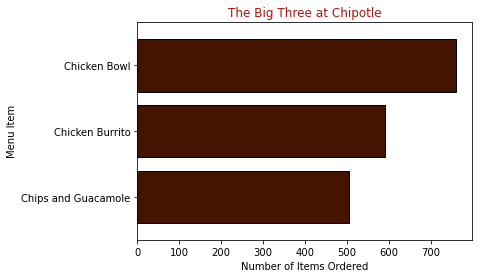

In [344]:
import matplotlib.pyplot as plt

# Make a bar plot
top_three.plot(kind='barh',
             color='#451400', 
             ec='black', 
             width=.8)

# add titles and labels
plt.title('The Big Three at Chipotle', fontdict={'color':'#a81612'})
plt.xlabel('Number of Items Ordered')
plt.ylabel('Menu Item')

# reorder y-axis of horizontal bar chart
plt.gca().invert_yaxis()


#### 4. Which item has produced the most revenue?


- We found that  `item_price` is really like a calulation of the quantity of an item in an order times the item's price.

In [356]:
# I can groupby item_name and aggregate the item_price.

orders.groupby('item_name')[['item_price']].sum().sort_values(by = 'item_price', ascending = False).head(1)

,item_price
item_name,
Chicken Bowl,7342.73


#### 5. Join the employees and titles DataFrames together.

In [297]:
# get inner join of employees and titles joining on emp_no for both
employee_titles = pd.merge(employees, titles, left_on='emp_no', right_on='emp_no')
employee_titles.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,title,from_date,to_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,Senior Engineer,1986-06-26,9999-01-01
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,Staff,1996-08-03,9999-01-01
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,Senior Engineer,1995-12-03,9999-01-01
3,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Engineer,1986-12-01,1995-12-01
4,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Senior Engineer,1995-12-01,9999-01-01


#### 6. For each title, find the hire date of the employee that was hired most recently with that title.

In [359]:
employee_titles.groupby('title')[['hire_date']].max()

,hire_date
title,
Assistant Engineer,1999-12-24
Engineer,2000-01-28
Manager,1992-02-05
Senior Engineer,2000-01-01
Senior Staff,2000-01-13
Staff,2000-01-12
Technique Leader,1999-12-31


#### 7. Write the code necessary to create a cross tabulation of the number of titles by department. (Hint: this will involve a combination of SQL code to pull the necessary data and python/pandas code to perform the manipulations.)

In [360]:
# My interpretation: cross tablulate data for latest dept and title for each employee


query = '''

SELECT emp_no, title, dept_name

FROM employees
JOIN titles USING(emp_no)
JOIN dept_emp USING(emp_no)
JOIN departments USING(dept_no)

where titles.to_date = "9999-01-01"
and dept_emp.to_date = "9999-01-01"

'''

# get url from function
url = get_db_url('employees')

# get dataframe from query and url using read_sql
df = pd.read_sql(query, url)


In [361]:
df.head()

,emp_no,title,dept_name
0,10001,Senior Engineer,Development
1,10002,Staff,Sales
2,10003,Senior Engineer,Production
3,10004,Senior Engineer,Production
4,10005,Senior Staff,Human Resources


In [362]:
df.shape

(240124, 3)

In [363]:
# use pd.crosstab to create cross tabulation
pd.crosstab(df.dept_name, df.title)

title,Assistant Engineer,Engineer,Manager,Senior Engineer,Senior Staff,Staff,Technique Leader
dept_name,,,,,,,
Customer Service,68,627,1,1790,11268,3574,241
Development,1652,14040,1,38816,1085,315,5477
Finance,0,0,1,0,9545,2891,0
Human Resources,0,0,1,0,9824,3073,0
Marketing,0,0,1,0,11290,3551,0
Production,1402,12081,1,33625,1123,349,4723
Quality Management,389,3405,1,9458,0,0,1293
Research,77,830,1,2250,9092,2870,321
Sales,0,0,1,0,28797,8903,0


In [365]:
# using pivot_table or group by (?)
df.groupby(['title', 'dept_name']).emp_no.count()

title               dept_name         
Assistant Engineer  Customer Service         68
                    Development            1652
                    Production             1402
                    Quality Management      389
                    Research                 77
Engineer            Customer Service        627
                    Development           14040
                    Production            12081
                    Quality Management     3405
                    Research                830
Manager             Customer Service          1
                    Development               1
                    Finance                   1
                    Human Resources           1
                    Marketing                 1
                    Production                1
                    Quality Management        1
                    Research                  1
                    Sales                     1
Senior Engineer     Customer Service       1790
 